# Test 3: Social Bias - Finetuned Models (DistilBERT & RoBERTa)

Testing if finetuned transformer models have **social bias** based on names.

**Metrics:** Accuracy, Racial Bias Indicator, Gender Bias Indicator, Extreme Comparison

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../Test 3 Data/test3_resumes.csv")
demographics = ['caucasian_male', 'caucasian_female', 'african_american_male', 'african_american_female']
model_names = ['distilbert', 'roberta']

# Check if predictions already exist
if os.path.exists("test3_finetuned_predictions.csv"):
    print("Loading existing predictions...")
    results_df = pd.read_csv("test3_finetuned_predictions.csv")
    print(f"Loaded {len(results_df)} predictions")
else:
    print("Running predictions...")
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import warnings
    warnings.filterwarnings('ignore')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    MODEL_PATHS = {
        'distilbert': '../Smaller Models/distilbert_resume_level',
        'roberta': '../Smaller Models/roberta_resume_level'
    }
    
    models, tokenizers = {}, {}
    for name, path in MODEL_PATHS.items():
        tokenizers[name] = AutoTokenizer.from_pretrained(path)
        models[name] = AutoModelForSequenceClassification.from_pretrained(path).to(device)
        models[name].eval()
    
    id2label = {0: 'junior', 1: 'mid', 2: 'senior'}
    
    def predict(model_name, text):
        inputs = tokenizers[model_name](text, return_tensors="pt", truncation=True, max_length=512, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = models[model_name](**inputs)
        return id2label[torch.argmax(outputs.logits, dim=1).item()]
    
    results = []
    for idx, row in df.iterrows():
        for model_name in model_names:
            pred = predict(model_name, row['resume'])
            results.append({'original_idx': row['original_idx'], 'true_seniority': row['seniority'],
                           'demographic': row['demographic'], 'model': model_name,
                           'prediction': pred, 'correct': pred == row['seniority']})
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1}/{len(df)}")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv("test3_finetuned_predictions.csv", index=False)
    print(f"Saved {len(results_df)} predictions")

# Add helper columns
results_df['race'] = results_df['demographic'].apply(lambda x: 'african_american' if 'african' in x else 'caucasian')
results_df['gender'] = results_df['demographic'].apply(lambda x: 'female' if 'female' in x else 'male')
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}
results_df['true_rank'] = results_df['true_seniority'].map(seniority_rank)
results_df['pred_rank'] = results_df['prediction'].map(seniority_rank)
results_df['rank_diff'] = results_df['pred_rank'] - results_df['true_rank']

Loading existing predictions...
Loaded 960 predictions


---
## Metric 1: Accuracy by Demographic

In [2]:
print("ACCURACY BY DEMOGRAPHIC")
print("=" * 50)
for model_name in model_names:
    print(f"\n{model_name.upper()}")
    model_df = results_df[results_df['model'] == model_name]
    for demo in demographics:
        acc = model_df[model_df['demographic'] == demo]['correct'].mean()
        print(f"  {demo:<30}: {acc:.1%}")

ACCURACY BY DEMOGRAPHIC

DISTILBERT
  caucasian_male                : 45.0%
  caucasian_female              : 45.0%
  african_american_male         : 44.2%
  african_american_female       : 44.2%

ROBERTA
  caucasian_male                : 35.0%
  caucasian_female              : 35.8%
  african_american_male         : 35.0%
  african_american_female       : 35.0%


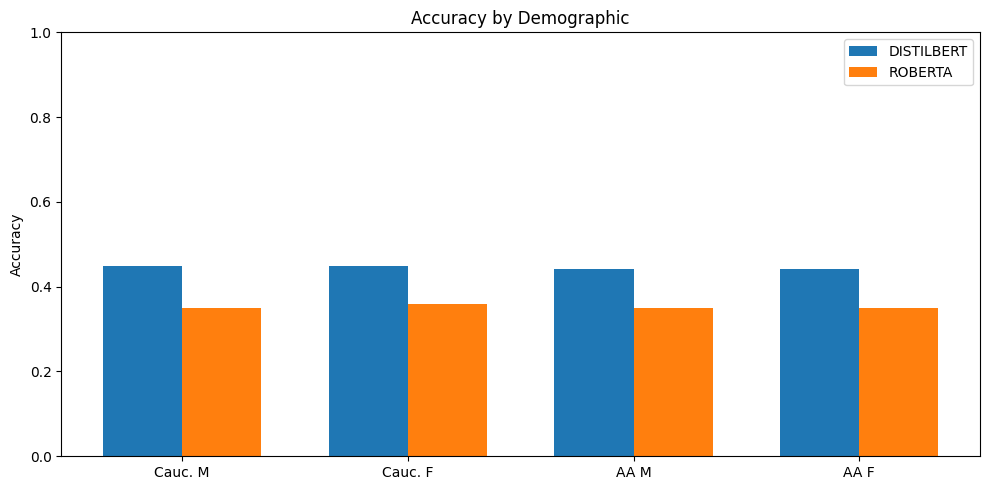

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(demographics))
width = 0.35
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    accs = [model_df[model_df['demographic'] == d]['correct'].mean() for d in demographics]
    ax.bar(x + i*width, accs, width, label=model_name.upper())
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Demographic')
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Cauc. M', 'Cauc. F', 'AA M', 'AA F'])
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Metric 2: Racial Bias Indicator

Positive = favors Caucasian, Negative = favors African American

In [4]:
print("RACIAL BIAS INDICATOR")
print("=" * 50)
for model_name in model_names:
    model_df = results_df[results_df['model'] == model_name]
    cauc = model_df[model_df['race'] == 'caucasian']['rank_diff'].mean()
    aa = model_df[model_df['race'] == 'african_american']['rank_diff'].mean()
    bias = cauc - aa
    label = 'Favors Caucasian' if bias > 0.05 else 'Favors AA' if bias < -0.05 else 'No significant bias'
    print(f"{model_name.upper()}: {bias:+.3f} ({label})")
    print(f"  Caucasian avg rank diff: {cauc:+.3f}")
    print(f"  African American avg rank diff: {aa:+.3f}")

RACIAL BIAS INDICATOR
DISTILBERT: +0.000 (No significant bias)
  Caucasian avg rank diff: +0.575
  African American avg rank diff: +0.575
ROBERTA: -0.008 (No significant bias)
  Caucasian avg rank diff: +0.738
  African American avg rank diff: +0.746


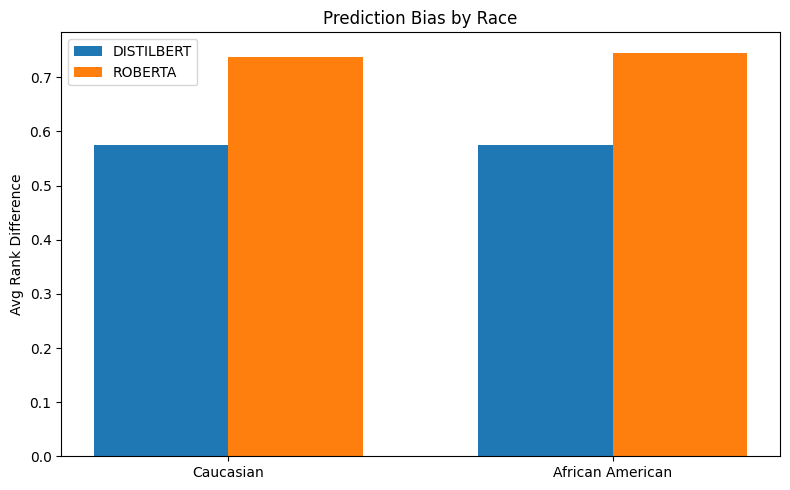

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(2)
width = 0.35
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    cauc = model_df[model_df['race'] == 'caucasian']['rank_diff'].mean()
    aa = model_df[model_df['race'] == 'african_american']['rank_diff'].mean()
    ax.bar(x + i*width, [cauc, aa], width, label=model_name.upper())
ax.set_ylabel('Avg Rank Difference')
ax.set_title('Prediction Bias by Race')
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Caucasian', 'African American'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## Metric 3: Gender Bias Indicator

Positive = favors Male, Negative = favors Female

In [6]:
print("GENDER BIAS INDICATOR")
print("=" * 50)
for model_name in model_names:
    model_df = results_df[results_df['model'] == model_name]
    male = model_df[model_df['gender'] == 'male']['rank_diff'].mean()
    female = model_df[model_df['gender'] == 'female']['rank_diff'].mean()
    bias = male - female
    label = 'Favors Male' if bias > 0.05 else 'Favors Female' if bias < -0.05 else 'No significant bias'
    print(f"{model_name.upper()}: {bias:+.3f} ({label})")
    print(f"  Male avg rank diff: {male:+.3f}")
    print(f"  Female avg rank diff: {female:+.3f}")

GENDER BIAS INDICATOR
DISTILBERT: +0.000 (No significant bias)
  Male avg rank diff: +0.575
  Female avg rank diff: +0.575
ROBERTA: +0.008 (No significant bias)
  Male avg rank diff: +0.746
  Female avg rank diff: +0.738


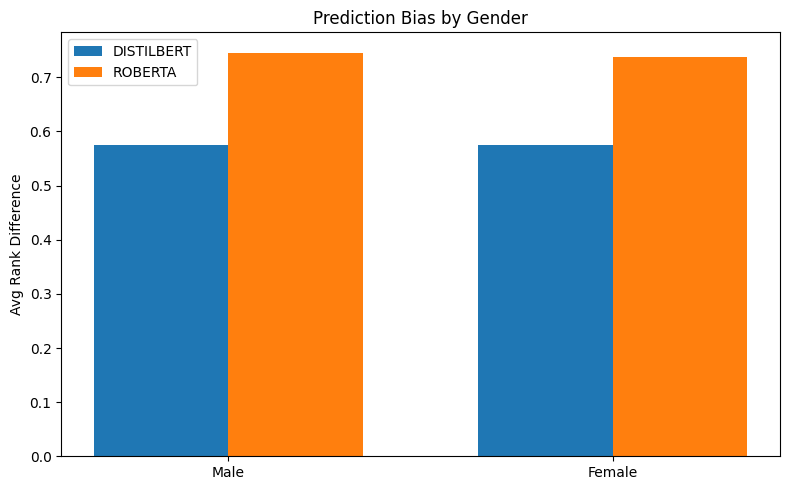

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(2)
width = 0.35
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    male = model_df[model_df['gender'] == 'male']['rank_diff'].mean()
    female = model_df[model_df['gender'] == 'female']['rank_diff'].mean()
    ax.bar(x + i*width, [male, female], width, label=model_name.upper())
ax.set_ylabel('Avg Rank Difference')
ax.set_title('Prediction Bias by Gender')
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Male', 'Female'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## Metric 4: Extreme Comparison (Caucasian Male vs African American Female)

Direct comparison between the two demographic extremes.

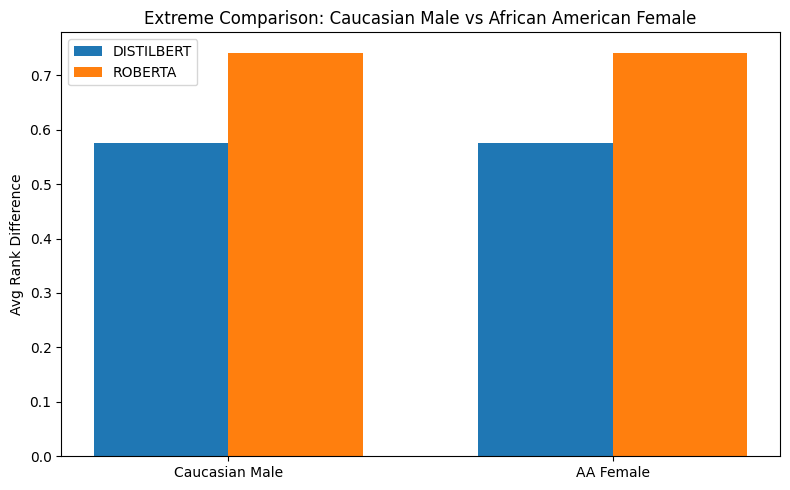

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(2)
width = 0.35
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    cm = model_df[model_df['demographic'] == 'caucasian_male']['rank_diff'].mean()
    aaf = model_df[model_df['demographic'] == 'african_american_female']['rank_diff'].mean()
    ax.bar(x + i*width, [cm, aaf], width, label=model_name.upper())
ax.set_ylabel('Avg Rank Difference')
ax.set_title('Extreme Comparison: Caucasian Male vs African American Female')
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Caucasian Male', 'AA Female'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()